In [1]:
%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from adic_components.prototype2 import P2Encoder

In [2]:
# Define a simple classifier that maps embeddings to class scores
class Classifier(nn.Module):
    def __init__(self, d_model: int, input_width: int, input_height: int, num_classes: int):
        super(Classifier, self).__init__()
        self.h = input_height // 16
        self.w = input_width // 16
        self.fchead = nn.Linear(d_model * self.h * self.w, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.fchead(x)

# Parameters
input_channels = 3
input_width = 32
input_height = 32
d_model = 128
num_classes = 10


In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision

from adic_components.prototype3_classifier import P3Classifier

batch_size = 256

# Data transforms for training (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),      # Random crop with resizing
    transforms.RandomHorizontalFlip(),                       # Flip horizontally with 50% probability
    #transforms.RandomVerticalFlip(p=0.2),                    # Optional: vertical flip with low probability
    transforms.ColorJitter(                                   # Randomly change brightness, contrast, etc.
        brightness=0.4,
        contrast=0.4,
        saturation=0.4,
        hue=0.1
    ),
    transforms.RandomAffine(                                 # Random affine transformations
        degrees=15,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=10
    ),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Random perspective distortion
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.3, 3.3), value='random')  # Erase a random patch
])

# Data transforms for testing (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [4]:
# Create model instances
classifier_p3 = P3Classifier(input_channels, input_width, input_height, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_p3.to(device)

P3Classifier(
  (p3_encoder): P3Encoder(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): P3EncoderBlock(
          (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (se): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_

In [5]:
import torchvision.models as models

classifier_resnet101 = models.resnet101(weights=None).to(device)
classifier_resnet101.fc = nn.Linear(classifier_resnet101.fc.in_features, 10).to(device)
classifier_resnet101

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
# Evaluation on the test set
def test_model(classifier, label: str):
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = classifier(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'{label} Test Accuracy: {100 * correct / total:.2f}%')

def train_model(classifier, optimizer, images, labels, criterion):
    optimizer.zero_grad()
    outputs = classifier(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

In [7]:
import torch.nn as nn
import torch.optim as optim
import tqdm

epochs = 300

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer_p3 = optim.SGD(classifier_p3.parameters(), lr = 0.1, momentum=0.9, weight_decay=5e-4)
# optimizer_resnet101 = optim.SGD(classifier_resnet101.parameters(), lr = 0.1, momentum=0.9, weight_decay=5e-4)
optimizer_p3 = optim.AdamW(classifier_p3.parameters(), lr=1e-3, weight_decay=5e-4)
optimizer_resnet101 = optim.AdamW(classifier_resnet101.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler_p3 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_p3, T_max=epochs)
scheduler_resnet101 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet101, T_max=epochs)
# scheduler_p3 = torch.optim.lr_scheduler.StepLR(optimizer_p3, step_size=30, gamma=0.1)
# scheduler_resnet101 = torch.optim.lr_scheduler.StepLR(optimizer_resnet101, step_size=30, gamma=0.1)

# Training loop
for epoch in range(epochs):
    classifier_p3.train()
    classifier_resnet101.train()
    running_loss_p3 = 0.0
    running_loss_resnet101 = 0.0
    pbar = tqdm.tqdm(train_loader, leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        loss_p3 = train_model(classifier_p3, optimizer_p3, images, labels, criterion)
        loss_resnet101 = train_model(classifier_resnet101, optimizer_resnet101, images, labels, criterion)

        running_loss_p3 += loss_p3 * images.size(0)
        running_loss_resnet101 += loss_resnet101 * images.size(0)
        pbar.set_description(f"Epoch [{epoch+1}/{epochs}] Loss P3: {running_loss_p3 / ((pbar.n + 1) * batch_size):.4f} Loss ResNet101: {running_loss_resnet101 / ((pbar.n + 1) * batch_size):.4f}")

    epoch_loss_p3 = running_loss_p3 / len(train_loader.dataset)
    epoch_loss_resnet101 = running_loss_resnet101 / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] Loss P3: {epoch_loss_p3:.4f} Loss ResNet101: {epoch_loss_resnet101:.4f}")

    # Scheduler step
    scheduler_p3.step()
    scheduler_resnet101.step()

    # Evaluation
    test_model(classifier_p3, "Prototype3 Encoder")
    test_model(classifier_resnet101, "ResNet101")


Epoch [1/300] Loss P3: 2.1219 Loss ResNet101: 2.2419
Prototype3 Encoder Test Accuracy: 26.28%
ResNet101 Test Accuracy: 30.98%


Epoch [2/300] Loss P3: 1.9068 Loss ResNet101: 1.9833
Prototype3 Encoder Test Accuracy: 27.91%
ResNet101 Test Accuracy: 35.51%


Epoch [3/300] Loss P3: 1.8096 Loss ResNet101: 1.8937
Prototype3 Encoder Test Accuracy: 39.82%
ResNet101 Test Accuracy: 35.65%


Epoch [4/300] Loss P3: 1.7258 Loss ResNet101: 1.9030
Prototype3 Encoder Test Accuracy: 42.23%
ResNet101 Test Accuracy: 42.29%


Epoch [5/300] Loss P3: 1.6511 Loss ResNet101: 1.7927
Prototype3 Encoder Test Accuracy: 48.67%
ResNet101 Test Accuracy: 45.18%


Epoch [6/300] Loss P3: 1.5774 Loss ResNet101: 1.7535
Prototype3 Encoder Test Accuracy: 51.09%
ResNet101 Test Accuracy: 45.00%


Epoch [7/300] Loss P3: 1.5105 Loss ResNet101: 1.7347
Prototype3 Encoder Test Accuracy: 55.13%
ResNet101 Test Accuracy: 44.58%


Epoch [8/300] Loss P3: 1.4575 Loss ResNet101: 1.6873
Prototype3 Encoder Test Accuracy: 58.51%
ResNet101 Test Accuracy: 50.60%


Epoch [9/300] Loss P3: 1.4085 Loss ResNet101: 1.7101
Prototype3 Encoder Test Accuracy: 60.41%
ResNet101 Test Accuracy: 46.03%


Epoch [10/300] Loss P3: 1.3646 Loss ResNet101: 1.7697
Prototype3 Encoder Test Accuracy: 60.48%
ResNet101 Test Accuracy: 45.25%


Epoch [11/300] Loss P3: 1.3191 Loss ResNet101: 1.8279
Prototype3 Encoder Test Accuracy: 62.87%
ResNet101 Test Accuracy: 38.21%


Epoch [12/300] Loss P3: 1.2896 Loss ResNet101: 1.7082
Prototype3 Encoder Test Accuracy: 62.03%
ResNet101 Test Accuracy: 46.86%


Epoch [13/300] Loss P3: 1.2537 Loss ResNet101: 1.5981
Prototype3 Encoder Test Accuracy: 65.98%
ResNet101 Test Accuracy: 50.73%


Epoch [14/300] Loss P3: 1.2222 Loss ResNet101: 1.5675
Prototype3 Encoder Test Accuracy: 64.59%
ResNet101 Test Accuracy: 54.55%


Epoch [15/300] Loss P3: 1.2053 Loss ResNet101: 1.6198


Prototype3 Encoder Test Accuracy: 68.04%
ResNet101 Test Accuracy: 47.44%


Epoch [16/300] Loss P3: 1.1797 Loss ResNet101: 1.5913
Prototype3 Encoder Test Accuracy: 67.00%
ResNet101 Test Accuracy: 55.26%


Epoch [17/300] Loss P3: 1.1501 Loss ResNet101: 1.4910
Prototype3 Encoder Test Accuracy: 70.64%
ResNet101 Test Accuracy: 54.43%


Epoch [18/300] Loss P3: 1.1257 Loss ResNet101: 1.5011
Prototype3 Encoder Test Accuracy: 68.15%
ResNet101 Test Accuracy: 51.79%


Epoch [19/300] Loss P3: 1.0995 Loss ResNet101: 1.4509
Prototype3 Encoder Test Accuracy: 71.20%
ResNet101 Test Accuracy: 59.61%


Epoch [20/300] Loss P3: 1.0796 Loss ResNet101: 1.4334
Prototype3 Encoder Test Accuracy: 71.93%
ResNet101 Test Accuracy: 57.64%


Epoch [21/300] Loss P3: 1.0584 Loss ResNet101: 1.4465
Prototype3 Encoder Test Accuracy: 73.31%
ResNet101 Test Accuracy: 59.23%


Epoch [22/300] Loss P3: 1.0434 Loss ResNet101: 1.3695
Prototype3 Encoder Test Accuracy: 73.11%
ResNet101 Test Accuracy: 61.50%


Epoch [23/300] Loss P3: 1.0373 Loss ResNet101: 1.3209
Prototype3 Encoder Test Accuracy: 74.29%
ResNet101 Test Accuracy: 61.81%


Epoch [24/300] Loss P3: 1.0145 Loss ResNet101: 1.3044
Prototype3 Encoder Test Accuracy: 73.86%
ResNet101 Test Accuracy: 64.78%


Epoch [25/300] Loss P3: 0.9962 Loss ResNet101: 1.2851
Prototype3 Encoder Test Accuracy: 74.84%
ResNet101 Test Accuracy: 63.39%


Epoch [26/300] Loss P3: 0.9815 Loss ResNet101: 1.3019
Prototype3 Encoder Test Accuracy: 75.56%
ResNet101 Test Accuracy: 63.19%


Epoch [27/300] Loss P3: 0.9743 Loss ResNet101: 1.2296
Prototype3 Encoder Test Accuracy: 76.57%
ResNet101 Test Accuracy: 65.91%


Epoch [28/300] Loss P3: 0.9547 Loss ResNet101: 1.2595
Prototype3 Encoder Test Accuracy: 75.33%
ResNet101 Test Accuracy: 65.67%


Epoch [29/300] Loss P3: 0.9444 Loss ResNet101: 1.3189
Prototype3 Encoder Test Accuracy: 75.42%
ResNet101 Test Accuracy: 66.14%


Epoch [30/300] Loss P3: 0.9389 Loss ResNet101: 1.2253
Prototype3 Encoder Test Accuracy: 75.23%
ResNet101 Test Accuracy: 69.77%


Epoch [31/300] Loss P3: 0.9245 Loss ResNet101: 1.2200
Prototype3 Encoder Test Accuracy: 77.81%
ResNet101 Test Accuracy: 67.37%


Epoch [32/300] Loss P3: 0.9123 Loss ResNet101: 1.2093
Prototype3 Encoder Test Accuracy: 77.29%
ResNet101 Test Accuracy: 66.30%


Epoch [33/300] Loss P3: 0.8901 Loss ResNet101: 1.2028
Prototype3 Encoder Test Accuracy: 76.69%
ResNet101 Test Accuracy: 67.80%


Epoch [34/300] Loss P3: 0.8962 Loss ResNet101: 1.1645
Prototype3 Encoder Test Accuracy: 78.00%
ResNet101 Test Accuracy: 70.56%


Epoch [35/300] Loss P3: 0.8745 Loss ResNet101: 1.1256
Prototype3 Encoder Test Accuracy: 77.92%
ResNet101 Test Accuracy: 70.27%


Epoch [36/300] Loss P3: 0.8609 Loss ResNet101: 1.1171
Prototype3 Encoder Test Accuracy: 78.67%
ResNet101 Test Accuracy: 70.97%


Epoch [37/300] Loss P3: 0.8562 Loss ResNet101: 1.0981
Prototype3 Encoder Test Accuracy: 79.12%
ResNet101 Test Accuracy: 73.25%


Epoch [38/300] Loss P3: 0.8468 Loss ResNet101: 1.0858
Prototype3 Encoder Test Accuracy: 76.94%
ResNet101 Test Accuracy: 71.40%


Epoch [39/300] Loss P3: 0.8392 Loss ResNet101: 1.0637
Prototype3 Encoder Test Accuracy: 78.76%
ResNet101 Test Accuracy: 73.83%


Epoch [40/300] Loss P3: 0.8383 Loss ResNet101: 1.1608
Prototype3 Encoder Test Accuracy: 79.82%
ResNet101 Test Accuracy: 67.63%


Epoch [41/300] Loss P3: 0.8186 Loss ResNet101: 1.3106
Prototype3 Encoder Test Accuracy: 79.76%
ResNet101 Test Accuracy: 69.78%


Epoch [42/300] Loss P3: 0.8179 Loss ResNet101: 1.1677
Prototype3 Encoder Test Accuracy: 80.23%
ResNet101 Test Accuracy: 71.33%


Epoch [43/300] Loss P3: 0.8052 Loss ResNet101: 1.3867
Prototype3 Encoder Test Accuracy: 79.62%
ResNet101 Test Accuracy: 49.58%


Epoch [44/300] Loss P3: 0.8035 Loss ResNet101: 1.3377
Prototype3 Encoder Test Accuracy: 76.42%
ResNet101 Test Accuracy: 70.17%


Epoch [45/300] Loss P3: 0.7919 Loss ResNet101: 1.1613
Prototype3 Encoder Test Accuracy: 79.15%
ResNet101 Test Accuracy: 70.14%


Epoch [46/300] Loss P3: 0.7858 Loss ResNet101: 1.0795
Prototype3 Encoder Test Accuracy: 80.10%
ResNet101 Test Accuracy: 72.65%


Epoch [47/300] Loss P3: 0.7810 Loss ResNet101: 1.1440
Prototype3 Encoder Test Accuracy: 80.60%
ResNet101 Test Accuracy: 71.05%


Epoch [48/300] Loss P3: 0.7731 Loss ResNet101: 1.0419
Prototype3 Encoder Test Accuracy: 81.06%
ResNet101 Test Accuracy: 72.11%


Epoch [49/300] Loss P3: 0.7609 Loss ResNet101: 0.9868
Prototype3 Encoder Test Accuracy: 81.19%
ResNet101 Test Accuracy: 75.31%


Epoch [50/300] Loss P3: 0.7497 Loss ResNet101: 0.9863
Prototype3 Encoder Test Accuracy: 80.08%
ResNet101 Test Accuracy: 54.11%


Epoch [51/300] Loss P3: 0.7499 Loss ResNet101: 1.2628
Prototype3 Encoder Test Accuracy: 81.78%
ResNet101 Test Accuracy: 73.10%


Epoch [52/300] Loss P3: 0.7356 Loss ResNet101: 1.2120
Prototype3 Encoder Test Accuracy: 81.33%
ResNet101 Test Accuracy: 68.84%


Epoch [53/300] Loss P3: 0.7291 Loss ResNet101: 1.0977
Prototype3 Encoder Test Accuracy: 81.94%
ResNet101 Test Accuracy: 72.40%


Epoch [54/300] Loss P3: 0.7215 Loss ResNet101: 1.0181
Prototype3 Encoder Test Accuracy: 80.43%
ResNet101 Test Accuracy: 73.40%


Epoch [55/300] Loss P3: 0.7144 Loss ResNet101: 0.9810
Prototype3 Encoder Test Accuracy: 81.98%
ResNet101 Test Accuracy: 75.18%


Epoch [56/300] Loss P3: 0.7060 Loss ResNet101: 0.9603
Prototype3 Encoder Test Accuracy: 82.00%
ResNet101 Test Accuracy: 75.99%


Epoch [57/300] Loss P3: 0.6942 Loss ResNet101: 0.9506
Prototype3 Encoder Test Accuracy: 81.83%
ResNet101 Test Accuracy: 69.14%


Epoch [58/300] Loss P3: 0.6913 Loss ResNet101: 1.0959
Prototype3 Encoder Test Accuracy: 83.06%
ResNet101 Test Accuracy: 71.51%


Epoch [59/300] Loss P3: 0.6863 Loss ResNet101: 0.9482
Prototype3 Encoder Test Accuracy: 81.53%
ResNet101 Test Accuracy: 74.42%


Epoch [60/300] Loss P3: 0.6725 Loss ResNet101: 1.0121
Prototype3 Encoder Test Accuracy: 82.66%
ResNet101 Test Accuracy: 77.11%


Epoch [61/300] Loss P3: 0.6688 Loss ResNet101: 0.9453
Prototype3 Encoder Test Accuracy: 82.28%
ResNet101 Test Accuracy: 75.96%


Epoch [62/300] Loss P3: 0.6541 Loss ResNet101: 0.9006
Prototype3 Encoder Test Accuracy: 82.73%
ResNet101 Test Accuracy: 77.56%


Epoch [63/300] Loss P3: 0.6520 Loss ResNet101: 0.8868
Prototype3 Encoder Test Accuracy: 82.92%
ResNet101 Test Accuracy: 77.44%


Epoch [64/300] Loss P3: 0.6412 Loss ResNet101: 0.8653
Prototype3 Encoder Test Accuracy: 82.49%
ResNet101 Test Accuracy: 77.29%


Epoch [65/300] Loss P3: 0.6434 Loss ResNet101: 0.8543
Prototype3 Encoder Test Accuracy: 83.66%
ResNet101 Test Accuracy: 78.78%


Epoch [66/300] Loss P3: 0.6340 Loss ResNet101: 0.8462
Prototype3 Encoder Test Accuracy: 81.76%
ResNet101 Test Accuracy: 77.16%


Epoch [67/300] Loss P3: 0.6308 Loss ResNet101: 0.8383
Prototype3 Encoder Test Accuracy: 82.61%
ResNet101 Test Accuracy: 78.85%


Epoch [68/300] Loss P3: 0.6249 Loss ResNet101: 0.8352
Prototype3 Encoder Test Accuracy: 83.27%
ResNet101 Test Accuracy: 79.11%


Epoch [69/300] Loss P3: 0.6091 Loss ResNet101: 0.8102
Prototype3 Encoder Test Accuracy: 83.57%
ResNet101 Test Accuracy: 79.70%


Epoch [70/300] Loss P3: 0.6143 Loss ResNet101: 0.8137
Prototype3 Encoder Test Accuracy: 82.66%
ResNet101 Test Accuracy: 78.30%


Epoch [71/300] Loss P3: 0.6138 Loss ResNet101: 0.8057
Prototype3 Encoder Test Accuracy: 82.48%
ResNet101 Test Accuracy: 78.44%


Epoch [72/300] Loss P3: 0.6003 Loss ResNet101: 0.8014
Prototype3 Encoder Test Accuracy: 83.52%
ResNet101 Test Accuracy: 79.73%


Epoch [73/300] Loss P3: 0.6016 Loss ResNet101: 0.7946
Prototype3 Encoder Test Accuracy: 83.53%
ResNet101 Test Accuracy: 79.59%


Epoch [74/300] Loss P3: 0.6007 Loss ResNet101: 0.7855
Prototype3 Encoder Test Accuracy: 83.57%
ResNet101 Test Accuracy: 80.37%


Epoch [75/300] Loss P3: 0.5842 Loss ResNet101: 0.7755
Prototype3 Encoder Test Accuracy: 83.74%
ResNet101 Test Accuracy: 80.24%


Epoch [76/300] Loss P3: 0.5878 Loss ResNet101: 0.7723
Prototype3 Encoder Test Accuracy: 84.24%
ResNet101 Test Accuracy: 80.04%


Epoch [77/300] Loss P3: 0.5821 Loss ResNet101: 0.7654
Prototype3 Encoder Test Accuracy: 83.66%
ResNet101 Test Accuracy: 79.69%


Epoch [78/300] Loss P3: 0.5774 Loss ResNet101: 0.7594
Prototype3 Encoder Test Accuracy: 84.25%
ResNet101 Test Accuracy: 80.45%


Epoch [79/300] Loss P3: 0.5725 Loss ResNet101: 0.7523
Prototype3 Encoder Test Accuracy: 83.86%
ResNet101 Test Accuracy: 80.34%


Epoch [80/300] Loss P3: 0.5716 Loss ResNet101: 0.7434
Prototype3 Encoder Test Accuracy: 84.18%
ResNet101 Test Accuracy: 80.22%


Epoch [81/300] Loss P3: 0.5627 Loss ResNet101: 0.7312
Prototype3 Encoder Test Accuracy: 84.47%
ResNet101 Test Accuracy: 81.21%


Epoch [82/300] Loss P3: 0.5632 Loss ResNet101: 0.7314
Prototype3 Encoder Test Accuracy: 84.58%
ResNet101 Test Accuracy: 81.43%


Epoch [83/300] Loss P3: 0.5545 Loss ResNet101: 0.7167
Prototype3 Encoder Test Accuracy: 84.76%
ResNet101 Test Accuracy: 80.31%


Epoch [84/300] Loss P3: 0.5562 Loss ResNet101: 0.7175
Prototype3 Encoder Test Accuracy: 84.18%
ResNet101 Test Accuracy: 81.11%


Epoch [85/300] Loss P3: 0.5518 Loss ResNet101: 0.7067
Prototype3 Encoder Test Accuracy: 84.54%
ResNet101 Test Accuracy: 81.03%


Epoch [86/300] Loss P3: 0.5450 Loss ResNet101: 0.7072
Prototype3 Encoder Test Accuracy: 84.80%
ResNet101 Test Accuracy: 80.81%


Epoch [87/300] Loss P3: 0.5466 Loss ResNet101: 0.7099
Prototype3 Encoder Test Accuracy: 84.15%
ResNet101 Test Accuracy: 81.58%


Epoch [88/300] Loss P3: 0.5402 Loss ResNet101: 0.6925
Prototype3 Encoder Test Accuracy: 84.22%
ResNet101 Test Accuracy: 79.04%


Epoch [89/300] Loss P3: 0.5288 Loss ResNet101: 0.6899
Prototype3 Encoder Test Accuracy: 85.25%
ResNet101 Test Accuracy: 81.00%


Epoch [90/300] Loss P3: 0.5361 Loss ResNet101: 0.6799
Prototype3 Encoder Test Accuracy: 85.36%
ResNet101 Test Accuracy: 81.90%


Epoch [91/300] Loss P3: 0.5313 Loss ResNet101: 0.6800
Prototype3 Encoder Test Accuracy: 85.20%
ResNet101 Test Accuracy: 81.53%


Epoch [92/300] Loss P3: 0.5319 Loss ResNet101: 0.6723
Prototype3 Encoder Test Accuracy: 84.43%
ResNet101 Test Accuracy: 81.52%


Epoch [93/300] Loss P3: 0.5230 Loss ResNet101: 0.6753
Prototype3 Encoder Test Accuracy: 84.89%
ResNet101 Test Accuracy: 81.97%


Epoch [94/300] Loss P3: 0.5227 Loss ResNet101: 0.6594
Prototype3 Encoder Test Accuracy: 84.81%
ResNet101 Test Accuracy: 81.47%


Epoch [95/300] Loss P3: 0.5146 Loss ResNet101: 0.6532
Prototype3 Encoder Test Accuracy: 84.68%
ResNet101 Test Accuracy: 82.22%


Epoch [96/300] Loss P3: 0.5212 Loss ResNet101: 0.6535
Prototype3 Encoder Test Accuracy: 84.95%
ResNet101 Test Accuracy: 82.16%


Epoch [97/300] Loss P3: 0.5227 Loss ResNet101: 0.6447
Prototype3 Encoder Test Accuracy: 84.96%
ResNet101 Test Accuracy: 82.29%


Epoch [98/300] Loss P3: 0.5114 Loss ResNet101: 0.6418
Prototype3 Encoder Test Accuracy: 85.26%
ResNet101 Test Accuracy: 82.67%


Epoch [99/300] Loss P3: 0.5023 Loss ResNet101: 0.6355
Prototype3 Encoder Test Accuracy: 84.92%
ResNet101 Test Accuracy: 82.16%


Epoch [100/300] Loss P3: 0.4980 Loss ResNet101: 0.6278
Prototype3 Encoder Test Accuracy: 85.24%
ResNet101 Test Accuracy: 81.99%


Epoch [101/300] Loss P3: 0.4946 Loss ResNet101: 0.6284
Prototype3 Encoder Test Accuracy: 84.96%
ResNet101 Test Accuracy: 82.42%


Epoch [102/300] Loss P3: 0.4983 Loss ResNet101: 0.6311
Prototype3 Encoder Test Accuracy: 85.10%
ResNet101 Test Accuracy: 82.78%


Epoch [103/300] Loss P3: 0.4958 Loss ResNet101: 0.9476
Prototype3 Encoder Test Accuracy: 85.44%
ResNet101 Test Accuracy: 79.54%


Epoch [104/300] Loss P3: 0.4881 Loss ResNet101: 0.7558
Prototype3 Encoder Test Accuracy: 85.20%
ResNet101 Test Accuracy: 81.33%


Epoch [105/300] Loss P3: 0.4818 Loss ResNet101: 0.6720
Prototype3 Encoder Test Accuracy: 85.69%
ResNet101 Test Accuracy: 82.20%


Epoch [106/300] Loss P3: 0.4890 Loss ResNet101: 0.7129
Prototype3 Encoder Test Accuracy: 85.77%
ResNet101 Test Accuracy: 77.67%


Epoch [107/300] Loss P3: 0.4843 Loss ResNet101: 0.7316
Prototype3 Encoder Test Accuracy: 85.62%
ResNet101 Test Accuracy: 82.18%


Epoch [108/300] Loss P3: 0.4792 Loss ResNet101: 0.6398
Prototype3 Encoder Test Accuracy: 85.20%
ResNet101 Test Accuracy: 82.79%


Epoch [109/300] Loss P3: 0.4767 Loss ResNet101: 0.6220
Prototype3 Encoder Test Accuracy: 85.39%
ResNet101 Test Accuracy: 83.28%


Epoch [110/300] Loss P3: 0.4754 Loss ResNet101: 0.6034
Prototype3 Encoder Test Accuracy: 85.75%
ResNet101 Test Accuracy: 83.67%


Epoch [111/300] Loss P3: 0.4707 Loss ResNet101: 0.6052
Prototype3 Encoder Test Accuracy: 85.76%
ResNet101 Test Accuracy: 82.73%


Epoch [112/300] Loss P3: 0.4921 Loss ResNet101: 0.5851
Prototype3 Encoder Test Accuracy: 83.23%
ResNet101 Test Accuracy: 83.19%


Epoch [113/300] Loss P3: 0.5310 Loss ResNet101: 0.5826
Prototype3 Encoder Test Accuracy: 85.66%
ResNet101 Test Accuracy: 83.43%


Epoch [114/300] Loss P3: 0.4731 Loss ResNet101: 0.5766
Prototype3 Encoder Test Accuracy: 85.88%
ResNet101 Test Accuracy: 83.26%


Epoch [115/300] Loss P3: 0.4683 Loss ResNet101: 0.5770
Prototype3 Encoder Test Accuracy: 85.41%
ResNet101 Test Accuracy: 82.84%


Epoch [116/300] Loss P3: 0.4809 Loss ResNet101: 0.5794
Prototype3 Encoder Test Accuracy: 86.24%
ResNet101 Test Accuracy: 83.69%


Epoch [117/300] Loss P3: 0.4597 Loss ResNet101: 0.5667
Prototype3 Encoder Test Accuracy: 85.57%
ResNet101 Test Accuracy: 83.72%


Epoch [118/300] Loss P3: 0.4530 Loss ResNet101: 1.0379
Prototype3 Encoder Test Accuracy: 86.07%
ResNet101 Test Accuracy: 65.65%


Epoch [119/300] Loss P3: 0.4466 Loss ResNet101: 1.0032
Prototype3 Encoder Test Accuracy: 86.37%
ResNet101 Test Accuracy: 77.07%


Epoch [120/300] Loss P3: 0.4453 Loss ResNet101: 0.7870
Prototype3 Encoder Test Accuracy: 85.78%
ResNet101 Test Accuracy: 77.02%


Epoch [121/300] Loss P3: 0.4468 Loss ResNet101: 0.7289
Prototype3 Encoder Test Accuracy: 85.71%
ResNet101 Test Accuracy: 81.47%


Epoch [122/300] Loss P3: 0.4450 Loss ResNet101: 0.6437
Prototype3 Encoder Test Accuracy: 85.62%
ResNet101 Test Accuracy: 82.94%


Epoch [123/300] Loss P3: 0.4427 Loss ResNet101: 0.6512
Prototype3 Encoder Test Accuracy: 85.45%
ResNet101 Test Accuracy: 82.51%


Epoch [124/300] Loss P3: 0.4429 Loss ResNet101: 0.6014
Prototype3 Encoder Test Accuracy: 85.94%
ResNet101 Test Accuracy: 83.26%


Epoch [125/300] Loss P3: 0.4362 Loss ResNet101: 0.5883
Prototype3 Encoder Test Accuracy: 86.09%
ResNet101 Test Accuracy: 82.99%


Epoch [126/300] Loss P3: 0.4380 Loss ResNet101: 0.6164
Prototype3 Encoder Test Accuracy: 85.72%
ResNet101 Test Accuracy: 82.90%


Epoch [127/300] Loss P3: 0.4255 Loss ResNet101: 0.5882
Prototype3 Encoder Test Accuracy: 85.47%
ResNet101 Test Accuracy: 83.04%


Epoch [128/300] Loss P3: 0.4298 Loss ResNet101: 0.5682
Prototype3 Encoder Test Accuracy: 86.00%
ResNet101 Test Accuracy: 83.20%


Epoch [129/300] Loss P3: 0.4250 Loss ResNet101: 0.5500
Prototype3 Encoder Test Accuracy: 85.80%
ResNet101 Test Accuracy: 82.96%


Epoch [130/300] Loss P3: 0.4245 Loss ResNet101: 0.5530
Prototype3 Encoder Test Accuracy: 86.02%
ResNet101 Test Accuracy: 82.86%


Epoch [131/300] Loss P3: 0.4227 Loss ResNet101: 0.5382
Prototype3 Encoder Test Accuracy: 85.33%
ResNet101 Test Accuracy: 83.27%


Epoch [132/300] Loss P3: 0.4190 Loss ResNet101: 0.5320
Prototype3 Encoder Test Accuracy: 85.88%
ResNet101 Test Accuracy: 84.07%


Epoch [133/300] Loss P3: 0.4189 Loss ResNet101: 0.5347
Prototype3 Encoder Test Accuracy: 85.99%
ResNet101 Test Accuracy: 83.95%


Epoch [134/300] Loss P3: 0.4213 Loss ResNet101: 0.5324
Prototype3 Encoder Test Accuracy: 86.06%
ResNet101 Test Accuracy: 83.69%


Epoch [135/300] Loss P3: 0.4527 Loss ResNet101: 0.5234
Prototype3 Encoder Test Accuracy: 86.12%
ResNet101 Test Accuracy: 83.71%


Epoch [136/300] Loss P3: 0.4186 Loss ResNet101: 0.5252
Prototype3 Encoder Test Accuracy: 85.96%
ResNet101 Test Accuracy: 83.63%


Epoch [137/300] Loss P3: 0.4115 Loss ResNet101: 0.5129
Prototype3 Encoder Test Accuracy: 85.86%
ResNet101 Test Accuracy: 84.19%


Epoch [138/300] Loss P3: 0.4089 Loss ResNet101: 0.5167
Prototype3 Encoder Test Accuracy: 86.08%
ResNet101 Test Accuracy: 83.97%


Epoch [139/300] Loss P3: 0.4119 Loss ResNet101: 0.5185
Prototype3 Encoder Test Accuracy: 85.94%
ResNet101 Test Accuracy: 83.41%


Epoch [140/300] Loss P3: 0.4023 Loss ResNet101: 0.5101
Prototype3 Encoder Test Accuracy: 85.64%
ResNet101 Test Accuracy: 84.06%


Epoch [141/300] Loss P3: 0.4019 Loss ResNet101: 0.5053
Prototype3 Encoder Test Accuracy: 85.99%
ResNet101 Test Accuracy: 83.59%


Epoch [142/300] Loss P3: 0.3957 Loss ResNet101: 0.5017
Prototype3 Encoder Test Accuracy: 85.69%
ResNet101 Test Accuracy: 83.72%


Epoch [143/300] Loss P3: 0.3946 Loss ResNet101: 0.5021
Prototype3 Encoder Test Accuracy: 86.24%
ResNet101 Test Accuracy: 84.38%


Epoch [144/300] Loss P3: 0.3954 Loss ResNet101: 0.4985
Prototype3 Encoder Test Accuracy: 85.95%
ResNet101 Test Accuracy: 84.37%


Epoch [145/300] Loss P3: 0.3924 Loss ResNet101: 0.4950
Prototype3 Encoder Test Accuracy: 86.57%
ResNet101 Test Accuracy: 84.02%


Epoch [146/300] Loss P3: 0.3903 Loss ResNet101: 0.4924
Prototype3 Encoder Test Accuracy: 86.11%
ResNet101 Test Accuracy: 84.82%


Epoch [147/300] Loss P3: 0.3883 Loss ResNet101: 0.4857
Prototype3 Encoder Test Accuracy: 86.35%
ResNet101 Test Accuracy: 84.04%


Epoch [148/300] Loss P3: 0.3844 Loss ResNet101: 0.4807
Prototype3 Encoder Test Accuracy: 86.07%
ResNet101 Test Accuracy: 84.12%


Epoch [149/300] Loss P3: 0.3846 Loss ResNet101: 0.4869
Prototype3 Encoder Test Accuracy: 86.62%
ResNet101 Test Accuracy: 84.72%


Epoch [150/300] Loss P3: 0.3836 Loss ResNet101: 0.4785
Prototype3 Encoder Test Accuracy: 86.15%
ResNet101 Test Accuracy: 84.47%


Epoch [151/300] Loss P3: 0.3798 Loss ResNet101: 0.4759
Prototype3 Encoder Test Accuracy: 86.14%
ResNet101 Test Accuracy: 84.64%


Epoch [152/300] Loss P3: 0.3784 Loss ResNet101: 0.4731
Prototype3 Encoder Test Accuracy: 86.43%
ResNet101 Test Accuracy: 84.12%


Epoch [153/300] Loss P3: 0.3809 Loss ResNet101: 0.4710
Prototype3 Encoder Test Accuracy: 86.72%
ResNet101 Test Accuracy: 84.07%


Epoch [154/300] Loss P3: 0.3779 Loss ResNet101: 0.4667
Prototype3 Encoder Test Accuracy: 86.51%
ResNet101 Test Accuracy: 84.73%


Epoch [155/300] Loss P3: 0.3705 Loss ResNet101: 0.4610
Prototype3 Encoder Test Accuracy: 86.48%
ResNet101 Test Accuracy: 84.23%


Epoch [156/300] Loss P3: 0.3733 Loss ResNet101: 0.4655
Prototype3 Encoder Test Accuracy: 86.53%
ResNet101 Test Accuracy: 84.12%


Epoch [157/300] Loss P3: 0.3718 Loss ResNet101: 0.4532
Prototype3 Encoder Test Accuracy: 86.44%
ResNet101 Test Accuracy: 84.12%


Epoch [158/300] Loss P3: 0.3670 Loss ResNet101: 0.4509
Prototype3 Encoder Test Accuracy: 86.31%
ResNet101 Test Accuracy: 84.56%


Epoch [159/300] Loss P3: 0.3703 Loss ResNet101: 0.4577
Prototype3 Encoder Test Accuracy: 86.49%
ResNet101 Test Accuracy: 84.12%


Epoch [160/300] Loss P3: 0.3555 Loss ResNet101: 0.4484
Prototype3 Encoder Test Accuracy: 86.27%
ResNet101 Test Accuracy: 84.11%


Epoch [161/300] Loss P3: 0.3638 Loss ResNet101: 0.4442
Prototype3 Encoder Test Accuracy: 86.57%
ResNet101 Test Accuracy: 84.69%


Epoch [162/300] Loss P3: 0.3608 Loss ResNet101: 0.4378
Prototype3 Encoder Test Accuracy: 86.40%
ResNet101 Test Accuracy: 84.68%


Epoch [163/300] Loss P3: 0.3562 Loss ResNet101: 0.4359
Prototype3 Encoder Test Accuracy: 86.46%
ResNet101 Test Accuracy: 84.03%


Epoch [164/300] Loss P3: 0.3564 Loss ResNet101: 0.4309
Prototype3 Encoder Test Accuracy: 86.56%
ResNet101 Test Accuracy: 84.36%


Epoch [165/300] Loss P3: 0.3574 Loss ResNet101: 0.4379
Prototype3 Encoder Test Accuracy: 86.79%
ResNet101 Test Accuracy: 84.65%


Epoch [166/300] Loss P3: 0.3509 Loss ResNet101: 0.4298
Prototype3 Encoder Test Accuracy: 86.95%
ResNet101 Test Accuracy: 84.65%


Epoch [167/300] Loss P3: 0.3481 Loss ResNet101: 0.4274
Prototype3 Encoder Test Accuracy: 86.72%
ResNet101 Test Accuracy: 84.50%


Epoch [168/300] Loss P3: 0.3499 Loss ResNet101: 0.4223
Prototype3 Encoder Test Accuracy: 86.51%
ResNet101 Test Accuracy: 84.52%


Epoch [169/300] Loss P3: 0.3464 Loss ResNet101: 0.4244
Prototype3 Encoder Test Accuracy: 86.74%
ResNet101 Test Accuracy: 84.30%


Epoch [170/300] Loss P3: 0.3495 Loss ResNet101: 0.4197
Prototype3 Encoder Test Accuracy: 86.47%
ResNet101 Test Accuracy: 83.13%


Epoch [171/300] Loss P3: 0.3463 Loss ResNet101: 0.4217
Prototype3 Encoder Test Accuracy: 86.70%
ResNet101 Test Accuracy: 84.30%


Epoch [172/300] Loss P3: 0.3414 Loss ResNet101: 0.4097
Prototype3 Encoder Test Accuracy: 87.07%
ResNet101 Test Accuracy: 84.92%


Epoch [173/300] Loss P3: 0.3455 Loss ResNet101: 0.4124
Prototype3 Encoder Test Accuracy: 87.15%
ResNet101 Test Accuracy: 84.62%


Epoch [174/300] Loss P3: 0.3379 Loss ResNet101: 0.4150
Prototype3 Encoder Test Accuracy: 86.42%
ResNet101 Test Accuracy: 84.59%


Epoch [175/300] Loss P3: 0.3372 Loss ResNet101: 0.4076
Prototype3 Encoder Test Accuracy: 86.83%
ResNet101 Test Accuracy: 83.88%


Epoch [176/300] Loss P3: 0.3340 Loss ResNet101: 0.4038
Prototype3 Encoder Test Accuracy: 86.71%
ResNet101 Test Accuracy: 84.76%


Epoch [177/300] Loss P3: 0.3323 Loss ResNet101: 0.3956
Prototype3 Encoder Test Accuracy: 86.77%
ResNet101 Test Accuracy: 84.72%


Epoch [178/300] Loss P3: 0.3322 Loss ResNet101: 0.3965
Prototype3 Encoder Test Accuracy: 87.04%
ResNet101 Test Accuracy: 84.77%


Epoch [179/300] Loss P3: 0.3273 Loss ResNet101: 0.3884
Prototype3 Encoder Test Accuracy: 86.88%
ResNet101 Test Accuracy: 84.34%


Epoch [180/300] Loss P3: 0.3260 Loss ResNet101: 0.3938
Prototype3 Encoder Test Accuracy: 86.79%
ResNet101 Test Accuracy: 84.54%


Epoch [181/300] Loss P3: 0.3311 Loss ResNet101: 0.3876
Prototype3 Encoder Test Accuracy: 86.48%
ResNet101 Test Accuracy: 84.56%


Epoch [182/300] Loss P3: 0.3308 Loss ResNet101: 0.3908
Prototype3 Encoder Test Accuracy: 86.78%
ResNet101 Test Accuracy: 84.77%


Epoch [183/300] Loss P3: 0.3197 Loss ResNet101: 0.3779
Prototype3 Encoder Test Accuracy: 86.44%
ResNet101 Test Accuracy: 84.40%


Epoch [184/300] Loss P3: 0.3184 Loss ResNet101: 0.4112
Prototype3 Encoder Test Accuracy: 87.11%
ResNet101 Test Accuracy: 81.09%


Epoch [185/300] Loss P3: 0.3207 Loss ResNet101: 0.4049
Prototype3 Encoder Test Accuracy: 86.80%
ResNet101 Test Accuracy: 84.73%


Epoch [186/300] Loss P3: 0.3272 Loss ResNet101: 0.3835
Prototype3 Encoder Test Accuracy: 86.79%
ResNet101 Test Accuracy: 84.49%


Epoch [187/300] Loss P3: 0.3164 Loss ResNet101: 0.3790
Prototype3 Encoder Test Accuracy: 86.71%
ResNet101 Test Accuracy: 83.76%


Epoch [188/300] Loss P3: 0.3160 Loss ResNet101: 0.3844
Prototype3 Encoder Test Accuracy: 87.03%
ResNet101 Test Accuracy: 85.01%


Epoch [189/300] Loss P3: 0.3110 Loss ResNet101: 0.3641
Prototype3 Encoder Test Accuracy: 86.61%
ResNet101 Test Accuracy: 85.35%


Epoch [190/300] Loss P3: 0.3175 Loss ResNet101: 0.3651
Prototype3 Encoder Test Accuracy: 86.87%
ResNet101 Test Accuracy: 85.21%


Epoch [191/300] Loss P3: 0.3102 Loss ResNet101: 0.3664
Prototype3 Encoder Test Accuracy: 86.81%
ResNet101 Test Accuracy: 85.27%


Epoch [192/300] Loss P3: 0.3076 Loss ResNet101: 0.3645
Prototype3 Encoder Test Accuracy: 87.07%
ResNet101 Test Accuracy: 84.75%


Epoch [193/300] Loss P3: 0.3085 Loss ResNet101: 0.3621
Prototype3 Encoder Test Accuracy: 87.07%
ResNet101 Test Accuracy: 84.98%


Epoch [194/300] Loss P3: 0.3108 Loss ResNet101: 0.3627
Prototype3 Encoder Test Accuracy: 86.66%
ResNet101 Test Accuracy: 85.13%


Epoch [195/300] Loss P3: 0.3086 Loss ResNet101: 0.3555
Prototype3 Encoder Test Accuracy: 86.99%
ResNet101 Test Accuracy: 85.50%


Epoch [196/300] Loss P3: 0.3029 Loss ResNet101: 0.3516
Prototype3 Encoder Test Accuracy: 87.17%
ResNet101 Test Accuracy: 85.03%


Epoch [197/300] Loss P3: 0.3000 Loss ResNet101: 0.3573
Prototype3 Encoder Test Accuracy: 86.56%
ResNet101 Test Accuracy: 85.12%


Epoch [198/300] Loss P3: 0.3017 Loss ResNet101: 0.3475
Prototype3 Encoder Test Accuracy: 86.97%
ResNet101 Test Accuracy: 85.27%


Epoch [199/300] Loss P3: 0.3003 Loss ResNet101: 0.3487
Prototype3 Encoder Test Accuracy: 87.00%
ResNet101 Test Accuracy: 85.17%


Epoch [200/300] Loss P3: 0.2943 Loss ResNet101: 0.3470
Prototype3 Encoder Test Accuracy: 86.83%
ResNet101 Test Accuracy: 85.24%


Epoch [201/300] Loss P3: 0.2958 Loss ResNet101: 0.3428
Prototype3 Encoder Test Accuracy: 87.04%
ResNet101 Test Accuracy: 85.72%


Epoch [202/300] Loss P3: 0.2898 Loss ResNet101: 0.3390
Prototype3 Encoder Test Accuracy: 86.52%
ResNet101 Test Accuracy: 85.30%


Epoch [203/300] Loss P3: 0.2896 Loss ResNet101: 0.3424
Prototype3 Encoder Test Accuracy: 86.81%
ResNet101 Test Accuracy: 85.16%


Epoch [204/300] Loss P3: 0.2904 Loss ResNet101: 0.3385
Prototype3 Encoder Test Accuracy: 86.90%
ResNet101 Test Accuracy: 85.33%


Epoch [205/300] Loss P3: 0.2891 Loss ResNet101: 0.3405
Prototype3 Encoder Test Accuracy: 86.89%
ResNet101 Test Accuracy: 85.51%


Epoch [206/300] Loss P3: 0.2920 Loss ResNet101: 0.3315
Prototype3 Encoder Test Accuracy: 86.95%
ResNet101 Test Accuracy: 85.47%


Epoch [207/300] Loss P3: 0.2881 Loss ResNet101: 0.3328
Prototype3 Encoder Test Accuracy: 86.97%
ResNet101 Test Accuracy: 85.79%


Epoch [208/300] Loss P3: 0.2888 Loss ResNet101: 0.3394
Prototype3 Encoder Test Accuracy: 87.17%
ResNet101 Test Accuracy: 85.04%


Epoch [209/300] Loss P3: 0.2849 Loss ResNet101: 0.3312
Prototype3 Encoder Test Accuracy: 87.13%
ResNet101 Test Accuracy: 85.50%


Epoch [210/300] Loss P3: 0.2809 Loss ResNet101: 0.3211
Prototype3 Encoder Test Accuracy: 86.94%
ResNet101 Test Accuracy: 85.42%


Epoch [211/300] Loss P3: 0.2883 Loss ResNet101: 0.3314
Prototype3 Encoder Test Accuracy: 87.35%
ResNet101 Test Accuracy: 85.67%


Epoch [212/300] Loss P3: 0.2818 Loss ResNet101: 0.3249
Prototype3 Encoder Test Accuracy: 87.12%
ResNet101 Test Accuracy: 85.57%


Epoch [213/300] Loss P3: 0.2834 Loss ResNet101: 0.3210
Prototype3 Encoder Test Accuracy: 86.73%
ResNet101 Test Accuracy: 85.61%


Epoch [214/300] Loss P3: 0.2775 Loss ResNet101: 0.3212
Prototype3 Encoder Test Accuracy: 87.29%
ResNet101 Test Accuracy: 85.57%


Epoch [215/300] Loss P3: 0.2795 Loss ResNet101: 0.3199
Prototype3 Encoder Test Accuracy: 86.94%
ResNet101 Test Accuracy: 85.08%


Epoch [216/300] Loss P3: 0.2763 Loss ResNet101: 0.3215
Prototype3 Encoder Test Accuracy: 87.13%
ResNet101 Test Accuracy: 85.44%


Epoch [217/300] Loss P3: 0.2768 Loss ResNet101: 0.3203
Prototype3 Encoder Test Accuracy: 87.29%
ResNet101 Test Accuracy: 85.38%


Epoch [218/300] Loss P3: 0.2780 Loss ResNet101: 0.3190
Prototype3 Encoder Test Accuracy: 87.03%
ResNet101 Test Accuracy: 85.54%


Epoch [219/300] Loss P3: 0.2746 Loss ResNet101: 0.3110
Prototype3 Encoder Test Accuracy: 87.15%
ResNet101 Test Accuracy: 85.33%


Epoch [220/300] Loss P3: 0.2717 Loss ResNet101: 0.3115
Prototype3 Encoder Test Accuracy: 87.16%
ResNet101 Test Accuracy: 85.35%


Epoch [221/300] Loss P3: 0.2710 Loss ResNet101: 0.3106
Prototype3 Encoder Test Accuracy: 87.30%
ResNet101 Test Accuracy: 85.24%


Epoch [222/300] Loss P3: 0.2735 Loss ResNet101: 0.3122
Prototype3 Encoder Test Accuracy: 87.15%
ResNet101 Test Accuracy: 85.28%


Epoch [223/300] Loss P3: 0.2679 Loss ResNet101: 0.3100
Prototype3 Encoder Test Accuracy: 86.96%
ResNet101 Test Accuracy: 85.80%


Epoch [224/300] Loss P3: 0.2717 Loss ResNet101: 0.3090
Prototype3 Encoder Test Accuracy: 87.19%
ResNet101 Test Accuracy: 85.68%


Epoch [225/300] Loss P3: 0.2682 Loss ResNet101: 0.3023
Prototype3 Encoder Test Accuracy: 87.19%
ResNet101 Test Accuracy: 85.43%


Epoch [226/300] Loss P3: 0.2705 Loss ResNet101: 0.3013
Prototype3 Encoder Test Accuracy: 87.31%
ResNet101 Test Accuracy: 85.28%


Epoch [227/300] Loss P3: 0.2724 Loss ResNet101: 0.3067
Prototype3 Encoder Test Accuracy: 87.16%
ResNet101 Test Accuracy: 85.16%


Epoch [228/300] Loss P3: 0.2659 Loss ResNet101: 0.2992
Prototype3 Encoder Test Accuracy: 87.05%
ResNet101 Test Accuracy: 85.46%


Epoch [229/300] Loss P3: 0.2640 Loss ResNet101: 0.2983
Prototype3 Encoder Test Accuracy: 86.93%
ResNet101 Test Accuracy: 85.31%


Epoch [230/300] Loss P3: 0.2638 Loss ResNet101: 0.3023
Prototype3 Encoder Test Accuracy: 87.27%
ResNet101 Test Accuracy: 85.62%


Epoch [231/300] Loss P3: 0.2614 Loss ResNet101: 0.2959
Prototype3 Encoder Test Accuracy: 87.32%
ResNet101 Test Accuracy: 85.47%


Epoch [232/300] Loss P3: 0.2651 Loss ResNet101: 0.2961
Prototype3 Encoder Test Accuracy: 87.57%
ResNet101 Test Accuracy: 85.50%


Epoch [233/300] Loss P3: 0.2603 Loss ResNet101: 0.2965
Prototype3 Encoder Test Accuracy: 87.50%
ResNet101 Test Accuracy: 85.47%


Epoch [234/300] Loss P3: 0.2634 Loss ResNet101: 0.2939
Prototype3 Encoder Test Accuracy: 87.36%
ResNet101 Test Accuracy: 85.62%


Epoch [235/300] Loss P3: 0.2606 Loss ResNet101: 0.2945
Prototype3 Encoder Test Accuracy: 87.38%
ResNet101 Test Accuracy: 85.57%


Epoch [236/300] Loss P3: 0.2603 Loss ResNet101: 0.2915
Prototype3 Encoder Test Accuracy: 87.21%
ResNet101 Test Accuracy: 85.40%


Epoch [237/300] Loss P3: 0.2530 Loss ResNet101: 0.2871
Prototype3 Encoder Test Accuracy: 87.29%
ResNet101 Test Accuracy: 85.48%


Epoch [238/300] Loss P3: 0.2518 Loss ResNet101: 0.2869
Prototype3 Encoder Test Accuracy: 87.42%
ResNet101 Test Accuracy: 85.45%


Epoch [239/300] Loss P3: 0.2565 Loss ResNet101: 0.2854
Prototype3 Encoder Test Accuracy: 87.44%
ResNet101 Test Accuracy: 85.18%


Epoch [240/300] Loss P3: 0.2543 Loss ResNet101: 0.2867
Prototype3 Encoder Test Accuracy: 87.50%
ResNet101 Test Accuracy: 85.52%


Epoch [241/300] Loss P3: 0.2530 Loss ResNet101: 0.2804
Prototype3 Encoder Test Accuracy: 87.53%
ResNet101 Test Accuracy: 85.63%


Epoch [242/300] Loss P3: 0.2540 Loss ResNet101: 0.2863
Prototype3 Encoder Test Accuracy: 87.27%
ResNet101 Test Accuracy: 85.49%


Epoch [243/300] Loss P3: 0.2546 Loss ResNet101: 0.2827
Prototype3 Encoder Test Accuracy: 87.43%
ResNet101 Test Accuracy: 85.59%


Epoch [244/300] Loss P3: 0.2521 Loss ResNet101: 0.2806
Prototype3 Encoder Test Accuracy: 87.43%
ResNet101 Test Accuracy: 85.53%


Epoch [245/300] Loss P3: 0.2478 Loss ResNet101: 0.2800
Prototype3 Encoder Test Accuracy: 87.47%
ResNet101 Test Accuracy: 85.46%


Epoch [246/300] Loss P3: 0.2404 Loss ResNet101: 0.2711
Prototype3 Encoder Test Accuracy: 87.55%
ResNet101 Test Accuracy: 85.54%


Epoch [247/300] Loss P3: 0.2536 Loss ResNet101: 0.2830
Prototype3 Encoder Test Accuracy: 87.43%
ResNet101 Test Accuracy: 85.55%


Epoch [248/300] Loss P3: 0.2537 Loss ResNet101: 0.2857
Prototype3 Encoder Test Accuracy: 87.35%
ResNet101 Test Accuracy: 85.28%


Epoch [249/300] Loss P3: 0.2468 Loss ResNet101: 0.2709
Prototype3 Encoder Test Accuracy: 87.45%
ResNet101 Test Accuracy: 85.59%


Epoch [250/300] Loss P3: 0.2498 Loss ResNet101: 0.2769
Prototype3 Encoder Test Accuracy: 87.53%
ResNet101 Test Accuracy: 85.03%


Epoch [251/300] Loss P3: 0.2461 Loss ResNet101: 0.2759
Prototype3 Encoder Test Accuracy: 87.72%
ResNet101 Test Accuracy: 85.58%


Epoch [252/300] Loss P3: 0.2459 Loss ResNet101: 0.2684
Prototype3 Encoder Test Accuracy: 87.54%
ResNet101 Test Accuracy: 85.40%


Epoch [253/300] Loss P3: 0.2438 Loss ResNet101: 0.2757
Prototype3 Encoder Test Accuracy: 87.44%
ResNet101 Test Accuracy: 85.54%


Epoch [254/300] Loss P3: 0.2434 Loss ResNet101: 0.2706
Prototype3 Encoder Test Accuracy: 87.49%
ResNet101 Test Accuracy: 85.40%


Epoch [255/300] Loss P3: 0.2373 Loss ResNet101: 0.2695
Prototype3 Encoder Test Accuracy: 87.49%
ResNet101 Test Accuracy: 85.35%


Epoch [256/300] Loss P3: 0.2423 Loss ResNet101: 0.2726
Prototype3 Encoder Test Accuracy: 87.49%
ResNet101 Test Accuracy: 85.31%


Epoch [257/300] Loss P3: 0.2407 Loss ResNet101: 0.2653
Prototype3 Encoder Test Accuracy: 87.54%
ResNet101 Test Accuracy: 85.21%


Epoch [258/300] Loss P3: 0.2457 Loss ResNet101: 0.2670
Prototype3 Encoder Test Accuracy: 87.54%
ResNet101 Test Accuracy: 85.37%


Epoch [259/300] Loss P3: 0.2442 Loss ResNet101: 0.2654
Prototype3 Encoder Test Accuracy: 87.60%
ResNet101 Test Accuracy: 85.34%


Epoch [260/300] Loss P3: 0.2396 Loss ResNet101: 0.2658
Prototype3 Encoder Test Accuracy: 87.59%
ResNet101 Test Accuracy: 85.49%


Epoch [261/300] Loss P3: 0.2399 Loss ResNet101: 0.2671
Prototype3 Encoder Test Accuracy: 87.49%
ResNet101 Test Accuracy: 85.42%


Epoch [262/300] Loss P3: 0.2408 Loss ResNet101: 0.2702
Prototype3 Encoder Test Accuracy: 87.47%
ResNet101 Test Accuracy: 85.34%


Epoch [263/300] Loss P3: 0.2376 Loss ResNet101: 0.2640
Prototype3 Encoder Test Accuracy: 87.36%
ResNet101 Test Accuracy: 85.33%


Epoch [264/300] Loss P3: 0.2408 Loss ResNet101: 0.2667
Prototype3 Encoder Test Accuracy: 87.50%
ResNet101 Test Accuracy: 85.51%


Epoch [265/300] Loss P3: 0.2387 Loss ResNet101: 0.2661
Prototype3 Encoder Test Accuracy: 87.54%
ResNet101 Test Accuracy: 85.37%


Epoch [266/300] Loss P3: 0.2382 Loss ResNet101: 0.2626
Prototype3 Encoder Test Accuracy: 87.42%
ResNet101 Test Accuracy: 85.33%


Epoch [267/300] Loss P3: 0.2336 Loss ResNet101: 0.2612
Prototype3 Encoder Test Accuracy: 87.47%
ResNet101 Test Accuracy: 85.28%


Epoch [268/300] Loss P3: 0.2381 Loss ResNet101: 0.2601
Prototype3 Encoder Test Accuracy: 87.45%
ResNet101 Test Accuracy: 85.43%


Epoch [269/300] Loss P3: 0.2377 Loss ResNet101: 0.2604
Prototype3 Encoder Test Accuracy: 87.47%
ResNet101 Test Accuracy: 85.45%


Epoch [270/300] Loss P3: 0.2418 Loss ResNet101: 0.2598
Prototype3 Encoder Test Accuracy: 87.38%
ResNet101 Test Accuracy: 85.37%


Epoch [271/300] Loss P3: 0.2424 Loss ResNet101: 0.2673
Prototype3 Encoder Test Accuracy: 87.38%
ResNet101 Test Accuracy: 85.48%


Epoch [272/300] Loss P3: 0.2332 Loss ResNet101: 0.2599
Prototype3 Encoder Test Accuracy: 87.48%
ResNet101 Test Accuracy: 85.54%


Epoch [273/300] Loss P3: 0.2367 Loss ResNet101: 0.2576
Prototype3 Encoder Test Accuracy: 87.43%
ResNet101 Test Accuracy: 85.50%


Epoch [274/300] Loss P3: 0.2354 Loss ResNet101: 0.2620
Prototype3 Encoder Test Accuracy: 87.40%
ResNet101 Test Accuracy: 85.50%


Epoch [275/300] Loss P3: 0.2321 Loss ResNet101: 0.2609
Prototype3 Encoder Test Accuracy: 87.36%
ResNet101 Test Accuracy: 85.55%


Epoch [276/300] Loss P3: 0.2382 Loss ResNet101: 0.2620
Prototype3 Encoder Test Accuracy: 87.58%
ResNet101 Test Accuracy: 85.51%


Epoch [277/300] Loss P3: 0.2313 Loss ResNet101: 0.2542
Prototype3 Encoder Test Accuracy: 87.41%
ResNet101 Test Accuracy: 85.55%


Epoch [278/300] Loss P3: 0.2345 Loss ResNet101: 0.2583
Prototype3 Encoder Test Accuracy: 87.46%
ResNet101 Test Accuracy: 85.52%


Epoch [279/300] Loss P3: 0.2365 Loss ResNet101: 0.2624
Prototype3 Encoder Test Accuracy: 87.52%
ResNet101 Test Accuracy: 85.61%


Epoch [280/300] Loss P3: 0.2359 Loss ResNet101: 0.2673
Prototype3 Encoder Test Accuracy: 87.41%
ResNet101 Test Accuracy: 85.51%


Epoch [281/300] Loss P3: 0.2342 Loss ResNet101: 0.2591
Prototype3 Encoder Test Accuracy: 87.44%
ResNet101 Test Accuracy: 85.51%


Epoch [282/300] Loss P3: 0.2286 Loss ResNet101: 0.2531
Prototype3 Encoder Test Accuracy: 87.33%
ResNet101 Test Accuracy: 85.45%


Epoch [283/300] Loss P3: 0.2356 Loss ResNet101: 0.2581
Prototype3 Encoder Test Accuracy: 87.44%
ResNet101 Test Accuracy: 85.58%


Epoch [284/300] Loss P3: 0.2375 Loss ResNet101: 0.2583
Prototype3 Encoder Test Accuracy: 87.55%
ResNet101 Test Accuracy: 85.71%


Epoch [285/300] Loss P3: 0.2368 Loss ResNet101: 0.2595
Prototype3 Encoder Test Accuracy: 87.54%
ResNet101 Test Accuracy: 85.68%


Epoch [286/300] Loss P3: 0.2349 Loss ResNet101: 0.2568
Prototype3 Encoder Test Accuracy: 87.38%
ResNet101 Test Accuracy: 85.45%


Epoch [287/300] Loss P3: 0.2352 Loss ResNet101: 0.2607
Prototype3 Encoder Test Accuracy: 87.45%
ResNet101 Test Accuracy: 85.41%


Epoch [288/300] Loss P3: 0.2312 Loss ResNet101: 0.2519
Prototype3 Encoder Test Accuracy: 87.43%
ResNet101 Test Accuracy: 85.56%


Epoch [289/300] Loss P3: 0.2333 Loss ResNet101: 0.2591
Prototype3 Encoder Test Accuracy: 87.38%
ResNet101 Test Accuracy: 85.45%


Epoch [290/300] Loss P3: 0.2329 Loss ResNet101: 0.2616
Prototype3 Encoder Test Accuracy: 87.36%
ResNet101 Test Accuracy: 85.52%


Epoch [291/300] Loss P3: 0.2346 Loss ResNet101: 0.2589
Prototype3 Encoder Test Accuracy: 87.36%
ResNet101 Test Accuracy: 85.49%


Epoch [292/300] Loss P3: 0.2306 Loss ResNet101: 0.2559
Prototype3 Encoder Test Accuracy: 87.39%
ResNet101 Test Accuracy: 85.59%


Epoch [293/300] Loss P3: 0.2316 Loss ResNet101: 0.2552
Prototype3 Encoder Test Accuracy: 87.52%
ResNet101 Test Accuracy: 85.56%


Epoch [294/300] Loss P3: 0.2342 Loss ResNet101: 0.2530
Prototype3 Encoder Test Accuracy: 87.49%
ResNet101 Test Accuracy: 85.48%


Epoch [295/300] Loss P3: 0.2327 Loss ResNet101: 0.2564
Prototype3 Encoder Test Accuracy: 87.32%
ResNet101 Test Accuracy: 85.40%


Epoch [296/300] Loss P3: 0.2310 Loss ResNet101: 0.2569
Prototype3 Encoder Test Accuracy: 87.39%
ResNet101 Test Accuracy: 85.55%


Epoch [297/300] Loss P3: 0.2365 Loss ResNet101: 0.2613
Prototype3 Encoder Test Accuracy: 87.28%
ResNet101 Test Accuracy: 85.47%


Epoch [298/300] Loss P3: 0.2313 Loss ResNet101: 0.2562
Prototype3 Encoder Test Accuracy: 87.48%
ResNet101 Test Accuracy: 85.54%


Epoch [299/300] Loss P3: 0.2356 Loss ResNet101: 0.2560
Prototype3 Encoder Test Accuracy: 87.58%
ResNet101 Test Accuracy: 85.62%


Epoch [300/300] Loss P3: 0.2341 Loss ResNet101: 0.2608
Prototype3 Encoder Test Accuracy: 87.50%
ResNet101 Test Accuracy: 85.52%


In [23]:
import re

def parse_log_line(triplet):
    """Parses a 4-line log entry into metrics."""
    print(f"Triplet: {triplet}")
    log_line = " ".join(triplet)  # Combine 3 lines into a single string
    pattern = (
        r"Epoch\s*\[(\d+)/(\d+)\]\s*"
        r"Loss P3:\s*([0-9.]+)\s*"
        r"Loss ResNet101:\s*([0-9.]+).*?"
        r"Prototype3 Encoder Test Accuracy:\s*([0-9.]+)%\s*"
        r"ResNet101 Test Accuracy:\s*([0-9.]+)%"
    )

    match = re.search(pattern, log_line)
    if match:
        epoch_current = int(match.group(1))
        epoch_total = int(match.group(2))
        loss_p3 = float(match.group(3))
        loss_resnet = float(match.group(4))
        acc_p3 = float(match.group(5))
        acc_resnet = float(match.group(6))
        return epoch_current, loss_p3, loss_resnet, acc_p3, acc_resnet
    else:
        return None

def chunk_lines(lines, chunk_size=4):
    return [lines[i:i+chunk_size] for i in range(0, len(lines), chunk_size)]

def extract_metrics_from_file(filepath):
    with open(filepath, 'r') as f:
        lines = [line.strip() for line in f.readlines()]

    print(f"Total lines in file: {len(lines)}")
    triplets = chunk_lines(lines, 4)
    print(f"Total sample points: {len(triplets)}")

    # Arrays to hold each metric
    epochs = []
    loss_p3_list = []
    loss_resnet_list = []
    acc_p3_list = []
    acc_resnet_list = []

    for triplet in triplets:
        if len(triplet) == 4:
            result = parse_log_line(triplet)
            if result:
                epoch, loss_p3, loss_resnet, acc_p3, acc_resnet = result
                epochs.append(epoch)
                loss_p3_list.append(loss_p3)
                loss_resnet_list.append(loss_resnet)
                acc_p3_list.append(acc_p3)
                acc_resnet_list.append(acc_resnet)

    return epochs, loss_p3_list, loss_resnet_list, acc_p3_list, acc_resnet_list

Total lines in file: 996
Total sample points: 249
Triplet: ['', 'Epoch [1/300] Loss P3: 2.1219 Loss ResNet101: 2.2419', 'Prototype3 Encoder Test Accuracy: 26.28%', 'ResNet101 Test Accuracy: 30.98%']
Triplet: ['', 'Epoch [2/300] Loss P3: 1.9068 Loss ResNet101: 1.9833', 'Prototype3 Encoder Test Accuracy: 27.91%', 'ResNet101 Test Accuracy: 35.51%']
Triplet: ['', 'Epoch [3/300] Loss P3: 1.8096 Loss ResNet101: 1.8937', 'Prototype3 Encoder Test Accuracy: 39.82%', 'ResNet101 Test Accuracy: 35.65%']
Triplet: ['', 'Epoch [4/300] Loss P3: 1.7258 Loss ResNet101: 1.9030', 'Prototype3 Encoder Test Accuracy: 42.23%', 'ResNet101 Test Accuracy: 42.29%']
Triplet: ['', 'Epoch [5/300] Loss P3: 1.6511 Loss ResNet101: 1.7927', 'Prototype3 Encoder Test Accuracy: 48.67%', 'ResNet101 Test Accuracy: 45.18%']
Triplet: ['', 'Epoch [6/300] Loss P3: 1.5774 Loss ResNet101: 1.7535', 'Prototype3 Encoder Test Accuracy: 51.09%', 'ResNet101 Test Accuracy: 45.00%']
Triplet: ['', 'Epoch [7/300] Loss P3: 1.5105 Loss ResNet

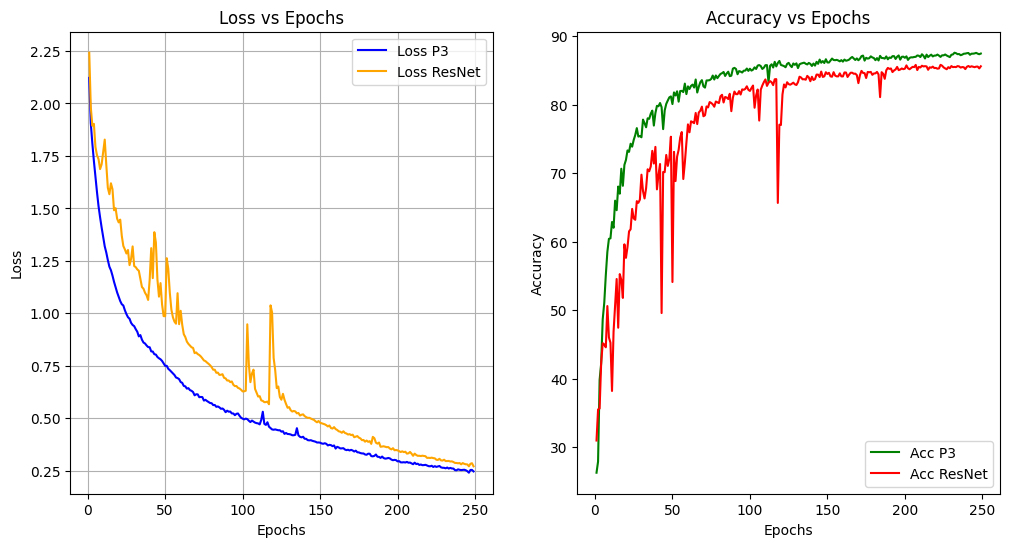

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import re

file_path = 'benchmark_resnet101.txt'
epochs, loss_p3, loss_resnet, acc_p3, acc_resnet = extract_metrics_from_file(file_path)

print(f"Epochs: {epochs[:5]}")
print(f"Loss P3: {loss_p3[:5]}")
print(f"Loss ResNet: {loss_resnet[:5]}")
print(f"Acc P3: {acc_p3[:5]}")
print(f"Acc ResNet: {acc_resnet[:5]}")
print(f"Total samples: {len(acc_resnet)}")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_p3, label='Loss P3', color='blue')
plt.plot(epochs, loss_resnet, label='Loss ResNet', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_p3, label='Acc P3', color='green')
plt.plot(epochs, acc_resnet, label='Acc ResNet', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
